# Cross Validation

In the previous class, we used train/test splitting to help assess our model performance on out of sample data.  However, this may still not be sufficient, especially if we have models that have hyperparameters that need to be tuned.  

In this situation we will need to re-run train/test multiple times with different hyperparameters to optimize them, however this can now lead to hyperparameter overfitting because we can overfit on the test data.

The solution for this is to utilize a technique called cross-validation.  In this scenario, we will split the training data into k even sets (e.g. 5 sets).  Then, k-1 sets are used to train the model, and the last set will be used to evaluate the model.  This is done across all k combinations, and the performance of the model is the average of all k runs.  After the best hyperparameter is chosen, we can then evaluate it on the test set to get the final result.

![Cross Validation](cross_validation.png)

An example:

In [83]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.datasets import load_iris

In [84]:
X, y = load_iris(return_X_y=True)

In [85]:
clf = SVC(kernel='linear', C=1, random_state=0)

In [86]:
scores = cross_val_score(clf, X, y, cv=5)
scores

array([0.96666667, 1.        , 0.96666667, 0.96666667, 1.        ])

In [87]:
scores.mean()

0.9800000000000001

In [88]:
clf = SVC(kernel='linear', C=100, random_state=0)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

0.9666666666666666

In [89]:
clf = SVC(kernel='linear', C=.1, random_state=0)
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

0.9733333333333334

In the above examples, we pass a model, as well as the input X and y data sets into the `cross_val_score` method.  The method will generate `cv` number of folds, and then train on the training set, predict on the fold's test set and evaluate the goodness of the model based on its `score` method.

While works nicely if there's a `score` method in the model, we might want to evaluate the model in some customized manner.  In that situation we will need to manually generate the folds for cross validation, then apply logic on the training and test data sets.

### Creating Cross-validation indices

To run kfolds manually, we can use the `KFolds` class to instantiate a KFold iterator, then split our data:

In [90]:
from sklearn.model_selection import KFold

In [97]:
cv = KFold(n_splits=5, shuffle=True)

In [98]:
for train_idx, test_idx in cv.split(range(20)):
    print(train_idx, test_idx)

[ 0  1  2  3  4  5  6  8  9 10 11 12 13 15 17 19] [ 7 14 16 18]
[ 0  1  2  3  6  7  9 10 11 12 14 15 16 17 18 19] [ 4  5  8 13]
[ 0  2  3  4  5  7  8 10 12 13 14 15 16 17 18 19] [ 1  6  9 11]
[ 0  1  2  3  4  5  6  7  8  9 11 13 14 15 16 18] [10 12 17 19]
[ 1  4  5  6  7  8  9 10 11 12 13 14 16 17 18 19] [ 0  2  3 15]


We can see from the above that kfolds chunks the data set into 5 separate chunks and in turn creates training and test indices for each iteration.  With these indices we can select the appropriate rows within the original X and y data sets to get our training and test sets.

There's also other strategies to cross validate, for example, we can run a leave one out strategy, where all samples except one is used for training, and only 1 sample is used for test:

In [99]:
from sklearn.model_selection import LeaveOneOut

In [100]:
cv = LeaveOneOut()
for train_idx, test_idx in cv.split(range(20)):
    print(train_idx, test_idx)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [0]
[ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [1]
[ 0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [2]
[ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [3]
[ 0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [4]
[ 0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19] [5]
[ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19] [6]
[ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19] [7]
[ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19] [8]
[ 0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19] [9]
[ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19] [10]
[ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19] [11]
[ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 15 16 17 18 19] [12]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19] [13]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19] [14]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 1

We can also shuffle and split the data, where we can specify the number of validations we want to do, as well as how large the test size is:

In [101]:
from sklearn.model_selection import ShuffleSplit

In [103]:
cv = ShuffleSplit(n_splits=5, test_size=0.20, random_state=0)
for train_idx, test_idx in cv.split(range(20)):
    print(train_idx, test_idx)

[10 17  6 13  4  2  5 14  9  7 16 11  3  0 15 12] [18  1 19  8]
[ 2 12 19 16 10  0  3  4 15  8 13  9  5 14  7  6] [11  1 18 17]
[11  2  8  6  3 17  4 10 16 18  9  1  0  7 14 19] [15 13 12  5]
[ 3 17  7 12 14 16 11 10  9 15  1 19  8  6  5  4] [18  0 13  2]
[ 5 18  8 17 15 16  6 13 11  4 10  9 12  3 14  0] [ 7  1  2 19]


so far, all the cross-validation strategies are focused on the feature set only.  However, we may want to create validation sets that are more balanced against the target variable - in this case there is a class of "stratified" cross validation strategies, which tries to create the same percentage of each target class in the complete set.  This is very useful for classification problems, where you don't want super skewed tests in some validations.

For example, the stratified version of KFold is Stratified KFold, where the main difference is that we need to put in the target variable to help with the splits:

In [105]:
from sklearn.model_selection import StratifiedKFold

In [106]:
X, y = np.ones((50, 1)), np.hstack(([0] * 45, [1] * 5))

In [109]:
cv = StratifiedKFold(n_splits=3)
for train, test in cv.split(X, y):
    print('train -  {}   |   test -  {}'.format(np.bincount(y[train]), np.bincount(y[test])))

train -  [30  3]   |   test -  [15  2]
train -  [30  3]   |   test -  [15  2]
train -  [30  4]   |   test -  [15  1]


In [112]:
cv = KFold(n_splits=3, shuffle=True)
for train, test in cv.split(X, y):
    print('train -  {}   |   test -  {}'.format(np.bincount(y[train]), np.bincount(y[test])))

train -  [29  4]   |   test -  [16  1]
train -  [29  4]   |   test -  [16  1]
train -  [32  2]   |   test -  [13  3]


In addition, there are stratified versions of the non-stratified cross validation strategies (e.g. Stratified Shuffle Split)

Lastly, as mentioned before, for time series specifically, we can use TimeSeriesSplit which will sequentially add more data to the training set, while using "unobserved" data as the test set.

In [113]:
from sklearn.model_selection import TimeSeriesSplit

In [114]:
cv = TimeSeriesSplit(n_splits=5)

In [115]:
for train_idx, test_idx in cv.split(range(20)):
    print(train_idx, test_idx)

[0 1 2 3 4] [5 6 7]
[0 1 2 3 4 5 6 7] [ 8  9 10]
[ 0  1  2  3  4  5  6  7  8  9 10] [11 12 13]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13] [14 15 16]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16] [17 18 19]


### Hyperparameter tuning

Now that we know how to create cross validation sets, we can tune hyperparameters of our model.  The general way to do this is to use a search technique to search across the space of hyperparameters given the data.  

Firstly, we can figure out what our available parameters are via the `get_params` function:

In [117]:
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Ridge

In [118]:
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [119]:
LinearRegression().get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [120]:
Ridge().get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

The simplest way to search for hyper-parameters is using a grid search, which will search across all dimensions specified in parameters.  To do this, we can wrap our base model into a grid search, and calling fit will run the grid search and identify the best model based on the model's `score` method, or some custom `scoring` function:

In [121]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import load_iris
from sklearn.svm import SVC

In [122]:
iris = load_iris()

In [128]:
# parameters = {'C': [1, 10, 100, 1000, 10000], 'kernel': ['linear', 'rbf'], 'tol': [0.001, 0.1]}

parameters = [
  {'C': [1, 10, 100], 'kernel': ['linear']},
  {'C': [1000, 10000], 'tol': [0.001, 0.1], 'kernel': ['rbf']},
 ]


In [132]:
svc = SVC()
clf = GridSearchCV(svc, parameters, scoring=None, refit=True)

clf.fit(iris.data, iris.target)

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [1, 10, 100], 'kernel': ['linear']},
                         {'C': [1000, 10000], 'kernel': ['rbf'],
                          'tol': [0.001, 0.1]}])

after we have searched, we can now get our best hyperparameters:

In [133]:
clf.best_params_

{'C': 1, 'kernel': 'linear'}

In [136]:
clf.best_estimator_

SVC(C=1, kernel='linear')

### Extra: Learning Curves

Once we can do basic cross validation, we can get a lot of very interesting data using the technique.  One example is that we can plot a learning curve, which shows the score of an Estimator for varying numbers of training samples.  This allows us to understand how much additional data will impact our model both in terms of its ability to generalize as well as its runtime.

In the example below, we can see that the SVM is much better for learning our digits data, however the cost of execution increases very aggressively with more samples, in a more than linear fashion.  This means that this model will get into trouble during training if the data set is large enough

In [ ]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

In [137]:
from sklearn.datasets import load_digits
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

from sklearn.naive_bayes import GaussianNB


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.8/site-packages/matplotlib/pyplot.py'>

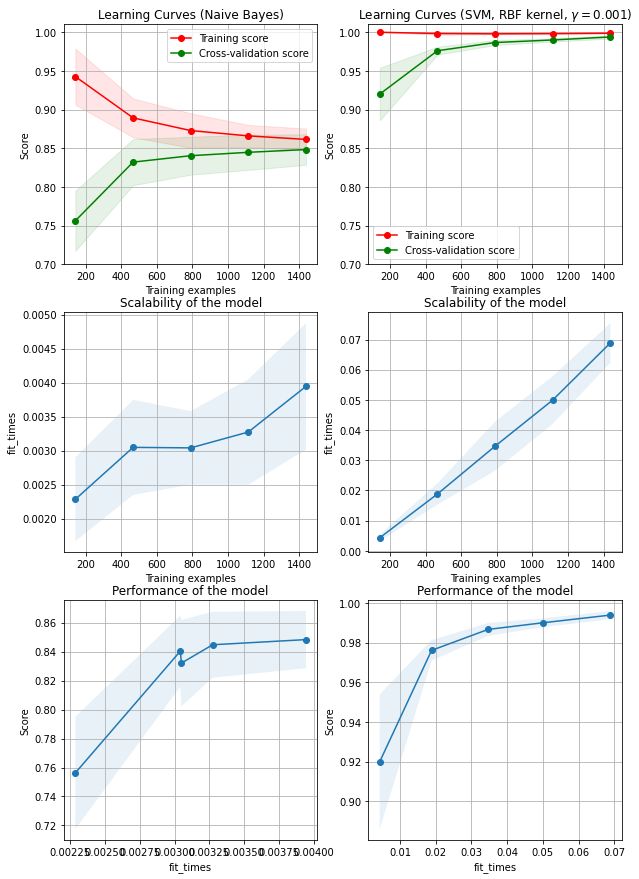

In [138]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = load_digits(return_X_y=True)

title = "Learning Curves (Naive Bayes)"
# Cross validation with 50 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(
    estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01), cv=cv, n_jobs=4
)
